# ANLY503 Project Machine Learning Part
## 1. Data Cleaning and Manipulation

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
combinedfile = pd.read_csv('combinedfile.csv',low_memory=False)

In [4]:
data_peeps=combinedfile.dropna(subset=['JOB_TITLE'])
data_peeps=data_peeps[data_peeps['JOB_TITLE'].str.contains('DATA')]
data_jobs=data_peeps[data_peeps['JOB_TITLE'].str.contains('DATA SCIENTIST|DATA ANALYST|DATA ENG')]

In [5]:
data_jobs=data_jobs.dropna(subset=['PREVAILING_WAGE'])

In [6]:
data_jobs = data_jobs[data_jobs['PREVAILING_WAGE']>20000]

In [7]:
data_jobs = data_jobs[data_jobs['CASE_STATUS'].isin(['CERTIFIED','DENIED'])]

In [8]:
data_jobs.isnull().sum()

CASE_STATUS           0
EMPLOYER_CITY         0
EMPLOYER_COUNTRY    785
EMPLOYER_NAME         0
EMPLOYER_STATE        0
H1B_DEPENDENT       275
JOB_TITLE             0
PREVAILING_WAGE       0
VISA_CLASS            0
WORKSITE_CITY         7
WORKSITE_COUNTY      55
WORKSITE_STATE        0
Year                  0
dtype: int64

In [9]:
data_jobs['H1B_DEPENDENT']=data_jobs['H1B_DEPENDENT'].fillna('N') #fill mode

In [10]:
data_jobs = data_jobs.reset_index()
data_jobs.head()

,index,CASE_STATUS,EMPLOYER_CITY,EMPLOYER_COUNTRY,EMPLOYER_NAME,EMPLOYER_STATE,H1B_DEPENDENT,JOB_TITLE,PREVAILING_WAGE,VISA_CLASS,WORKSITE_CITY,WORKSITE_COUNTY,WORKSITE_STATE,Year
0,9073,CERTIFIED,BOSTON,UNITED STATES OF AMERICA,"BOSTON MEDICAL CENTER HEALTH PLAN, INC.",MA,N,SENIOR HEALTH DATA ANALYST,77397.0,H-1B,BOSTON,SUFFOLK,MA,2015
1,11718,CERTIFIED,TACOMA,UNITED STATES OF AMERICA,"TRUEBLUE, INC.",WA,N,DATA ANALYST,63086.0,H-1B,TACOMA,PIERCE,WA,2015
2,12605,CERTIFIED,STERLING,UNITED STATES OF AMERICA,"BELL INFO SOLUTIONS, LLC",VA,Y,DATA ANALYST,58885.0,H-1B,FRISCO,DENTON,TX,2015
3,12913,CERTIFIED,STERLING,UNITED STATES OF AMERICA,"BELL INFO SOLUTIONS, LLC",VA,Y,DATA ANALYST,61818.0,H-1B,SACRAMENTO,SACRAMENTO,CA,2015
4,14834,CERTIFIED,REDWOOD CITY,UNITED STATES OF AMERICA,"SHUTTERFLY, INC.",CA,N,DATA ENGINEER,73923.0,H-1B,REDWOOD CITY,SAN MATEO,CA,2015


In [11]:
for i in range(len(data_jobs['WORKSITE_STATE'])):
    if data_jobs.loc[i,'WORKSITE_STATE'] not in ['CA','NY','WA']:
        data_jobs.loc[i,'WORKSITE_STATE'] ='Other'

In [12]:
for i in range(len(data_jobs['WORKSITE_STATE'])):
    if 'SCIENTIST' in data_jobs.loc[i,'JOB_TITLE']:
        data_jobs.loc[i,'JOB'] ='DATA_SCIENCE'
    elif 'ENGINEER' in data_jobs.loc[i,'JOB_TITLE']:
        data_jobs.loc[i,'JOB'] ='DATA_ENGINEER'
    else:
        data_jobs.loc[i,'JOB'] ='DATA_ANALYST'   

In [13]:
data_jobs['JOB'].groupby(data_jobs['JOB']).count()

JOB
DATA_ANALYST     13372
DATA_ENGINEER     6610
DATA_SCIENCE     11028
Name: JOB, dtype: int64

In [ ]:
#data_jobs.to_csv('data_jobs.csv',encoding='utf-8', index=False)

In [15]:
data_jobs = pd.read_csv("data_jobs.csv")

In [16]:
data_jobs['Year']=data_jobs['Year'].astype(object)

In [17]:
data_jobs.columns

Index(['index', 'CASE_STATUS', 'EMPLOYER_CITY', 'EMPLOYER_COUNTRY',
       'EMPLOYER_NAME', 'EMPLOYER_STATE', 'H1B_DEPENDENT', 'JOB_TITLE',
       'PREVAILING_WAGE', 'VISA_CLASS', 'WORKSITE_CITY', 'WORKSITE_COUNTY',
       'WORKSITE_STATE', 'Year', 'JOB'],
      dtype='object')

## 2. SVM Model

In [18]:
import random
random.seed(0)
djtotal = data_jobs.sample(frac=1)
dj = djtotal[0:20000]
dj1 = djtotal[20000:31010]

In [19]:
X1 = dj[dj['CASE_STATUS'] == 'CERTIFIED'] # We seperate the data which are the frauds and the no frauds
X0 = dj[dj['CASE_STATUS'] == 'DENIED']
n=len(X0)
n

189

99% are certified, so we balance the training data and use part of certified.

In [20]:
X_sample=X1.sample(3*n,random_state=10)

In [21]:
X = X0.append(X_sample)

In [22]:
X = X.sample(frac=1)

In [23]:
y = X['CASE_STATUS']
X = X[['H1B_DEPENDENT', 'PREVAILING_WAGE', 'VISA_CLASS','WORKSITE_STATE', 'Year', 'JOB']]

In [24]:
X.head()

,H1B_DEPENDENT,PREVAILING_WAGE,VISA_CLASS,WORKSITE_STATE,Year,JOB
16258,Y,63190.0,H-1B,Other,2018,DATA_ANALYST
13934,N,147888.0,H-1B,NY,2018,DATA_SCIENCE
19928,N,92997.0,H-1B,WA,2018,DATA_ENGINEER
13593,N,74734.0,H-1B,Other,2017,DATA_ANALYST
28912,N,94702.0,H-1B,Other,2019,DATA_ENGINEER


In [25]:
categorical_feature_mask = X.dtypes==object

In [26]:
categorical_cols = X.columns[categorical_feature_mask].tolist()

In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [28]:
le = LabelEncoder()

In [29]:
X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))

In [30]:
len(X[categorical_cols[0]])

756

In [31]:
from sklearn.preprocessing import OneHotEncoder

In [32]:
ohe = OneHotEncoder(categorical_features = categorical_feature_mask, sparse=False )

In [33]:
X_ohe = ohe.fit_transform(X)

In [34]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_ohe, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [35]:
ypred = dj1['CASE_STATUS']
Xpred = dj1[['H1B_DEPENDENT', 'PREVAILING_WAGE', 'VISA_CLASS','WORKSITE_STATE', 'Year', 'JOB']]

In [36]:
Xpred[categorical_cols] = Xpred[categorical_cols].apply(lambda col: le.fit_transform(col))

C:\Users\hujia\Anaconda3\lib\site-packages\pandas\core\frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [37]:
ohepred = OneHotEncoder(categorical_features = categorical_feature_mask, sparse=False)

In [38]:
Xpred_ohe = ohepred.fit_transform(Xpred)

In [40]:
y_pred = svclassifier.predict(Xpred_ohe)

In [41]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(np.asarray(ypred),y_pred))

[[10914     0]
 [   96     0]]


In [43]:
print(classification_report(np.asarray(ypred),y_pred))

             precision    recall  f1-score   support

  CERTIFIED       0.99      1.00      1.00     10914
     DENIED       0.00      0.00      0.00        96

avg / total       0.98      0.99      0.99     11010



C:\Users\hujia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [44]:
class_names=np.array(['Certified','Denied']) 

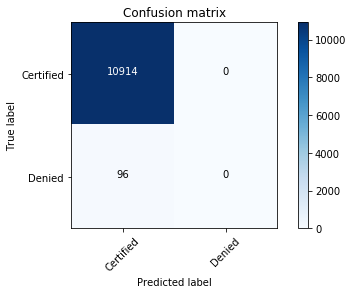

In [45]:
plot_confusion_matrix(confusion_matrix(np.asarray(ypred),y_pred),class_names)

In [46]:
svclassifier2 = SVC(kernel='rbf')
svclassifier2.fit(X_ohe, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [47]:
y_pred2 = svclassifier2.predict(Xpred_ohe)

In [48]:
print(confusion_matrix(np.asarray(ypred),y_pred2))

[[10353   561]
 [   79    17]]


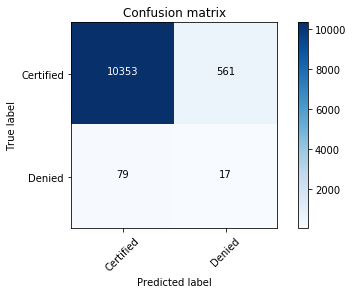

In [50]:
plot_confusion_matrix(confusion_matrix(np.asarray(ypred),y_pred2),class_names)

## 3. Logistic Model

In [51]:
from sklearn.linear_model import LogisticRegression

In [52]:
logreg = LogisticRegression()

In [53]:
logreg.fit(X_ohe, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [54]:
y_pred=logreg.predict(Xpred_ohe)

In [55]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(np.asarray(ypred), y_pred)
cnf_matrix

array([[10914,     0],
       [   96,     0]], dtype=int64)

In [56]:
y = le.fit_transform(ypred.to_frame())

C:\Users\hujia\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [57]:
probs_y = logreg.predict_proba(Xpred_ohe)

In [58]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve( y, probs_y[:, 1]) 

In [59]:
pr_auc = metrics.auc(recall, precision)

(0, 1)

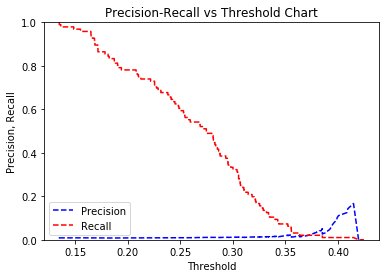

In [60]:
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [61]:
y_pred_prob=logreg.predict_proba(Xpred_ohe)

In [62]:
y_pred_prob[:,0]

array([0.74172308, 0.70113195, 0.72353185, ..., 0.77498154, 0.81525477,
       0.76331111])

In [63]:
Y_test_pred = pd.DataFrame(y_pred_prob[:,0]).applymap(lambda x: 'CERTIFIED' if x>0.65 else 'DENIED')

In [64]:
cnf_matrix2 = metrics.confusion_matrix(np.asarray(ypred), Y_test_pred)
cnf_matrix2

array([[10560,   354],
       [   89,     7]], dtype=int64)

In [65]:
ar = []
for i in [0.4,0.45,0.5,0.55,0.6,0.65]:
    Y_test_pred = pd.DataFrame(y_pred_prob[:,0]).applymap(lambda x: 'CERTIFIED' if x>i else 'DENIED')
    cnf_matrix3 = metrics.confusion_matrix(np.asarray(ypred), Y_test_pred)
    ar.append((cnf_matrix3[0][0]+cnf_matrix3[1][1])/11010)

In [66]:
ar

[0.9912806539509537,
 0.9912806539509537,
 0.9912806539509537,
 0.9912806539509537,
 0.9906448683015441,
 0.959763851044505]

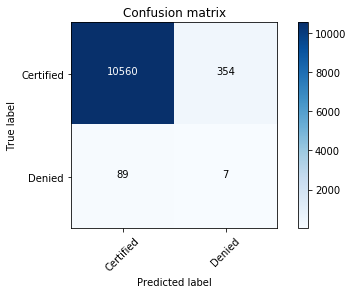

In [67]:
plot_confusion_matrix(cnf_matrix2,class_names)

## Linear Model to Predict Application Amount

In [68]:
tot_apply = np.array([342575,358816,415845,442275,519505,618804,647852,624650,654360])
x = np.array([1,2,3,4,5,6,7,8,9])
year = np.array([2010,2011,2012,2013,2014,2015,2016,2017,2018]).astype(object)

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [70]:
data = {'time':x,'app':tot_apply}

In [71]:
df3 = pd.DataFrame(data)

In [72]:
X = df3['time'].values.reshape(-1,1)
y = df3['app'].values.reshape(-1,1)

In [73]:
from sklearn.linear_model import LinearRegression
linreg  = LinearRegression()

In [74]:
linreg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [75]:
y_pred = linreg.predict(pd.DataFrame({'time':np.array([10,11,12])})['time'].values.reshape(-1,1))

In [76]:
np.round(y_pred,0)

array([[737619.],
       [782372.],
       [827125.]])

In [77]:
y1 = np.append(tot_apply,y_pred)
year1 = np.append(year,[2019,2020,2021])
#plt.plot(year1,y1)

In [78]:
import plotly.graph_objects as go

In [82]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.array([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]).astype(object), 
                         y= np.array([342575,358816,415845,442275,519505,618804,647852,624650,654360,737619]), name='Actual'+'<br>'+'实际',
                         line = dict(color='royalblue', width=2)))
fig.add_trace(go.Scatter(x=np.array([2019,2020,2021]).astype(object), y=np.array([737619,782372,827125]), name='Predict'+'<br>'+'预测',
                         line = dict(color='red', width=2)))
fig.update_layout(title='Prediction of Future H1b Application'+'<br>'+'H1b总申请量预测')
fig.update_xaxes(range=[2009.5, 2021.5])
fig.update_yaxes(range=[300000, 900000])
fig.show()


In [80]:
import chart_studio.plotly as py
py.sign_in('mengyingyy', '9AtRgIf047WY8od7cIyR')

In [83]:
py.iplot(fig, filename='ML')